#### <p><center> DABE - Deep Learning Final Project </center></p>

 #  <p><center> Facial Emotion Recognition using Deep Learning </center> </p>
### <p><center> Presented by: Gunel Aliyeva and Juliana Rojas </center></p>

In [1]:
# Importing required modules
from zipfile import ZipFile
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

csv_path = "data.csv"  
images_folder = "dataset/" 

# Load the CSV file
data = pd.read_csv(csv_path)

In [2]:
# Display the first few rows of the dataframe
data.head()

,Unnamed: 0,path,label
0,0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


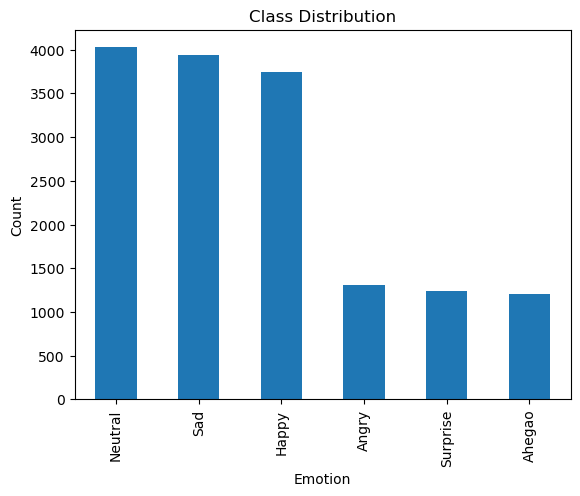

Number of images for each class:
label
Neutral     4027
Sad         3934
Happy       3740
Angry       1313
Surprise    1234
Ahegao      1205
Name: count, dtype: int64


In [3]:
# Check the distribution of classes
data['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

# Count the number of images for each class
class_counts = data['label'].value_counts()

# Display the counts
print("Number of images for each class:")
print(class_counts)

# Preprocessing

In [4]:
# Preprocessing
def load_and_preprocess_images(image_folder):
    image_data = []
    labels = []

    for index, row in data.iterrows():
        img_path = os.path.join(image_folder, row['path'])
        img = Image.open(img_path)
        img = img.resize((64, 64))  # Adjust the size as needed
        img = np.array(img) / 255.0  # Normalize the pixel values
        image_data.append(img)
        labels.append(row['label'])

    return np.array(image_data), np.array(labels)

# Load and preprocess images
images, labels = load_and_preprocess_images(images_folder)

In [5]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
encoded_labels = to_categorical(encoded_labels)


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

# Load and preprocess images with selective data augmentation
def load_and_preprocess_images(image_folder, augment=True):
    image_data = []
    labels = []

    for index, row in data.iterrows():
        img_path = os.path.join(image_folder, row['path'])
        img = Image.open(img_path)
        img = img.resize((64, 64))  # Adjust the size as needed
        img = np.array(img) / 255.0  # Normalize the pixel values
        image_data.append(img)
        labels.append(row['label'])

    image_data = np.array(image_data)
    labels = np.array(labels)

    if augment:
        # Create an ImageDataGenerator with various augmentation settings
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # Identify minority classes
        minority_classes = ['Angry', 'Surprise', 'Ahegao']

        # Apply data augmentation to the images of minority classes
        augmented_data = []
        augmented_labels = []

        for i in range(len(image_data)):
            img = image_data[i]
            label = labels[i]

            if label in minority_classes:
                # Reshape the image to (1, height, width, channels) as required by flow method
                img = img.reshape((1,) + img.shape)

                # Generate augmented images
                for batch in datagen.flow(img, batch_size=1):
                    augmented_data.append(batch[0])
                    augmented_labels.append(label)
                    break  # Break the loop to prevent infinite generation

        # Concatenate original and augmented data
        image_data = np.concatenate((image_data, np.array(augmented_data)))
        labels = np.concatenate((labels, np.array(augmented_labels)))

    return image_data, labels

# Load and preprocess images with selective data augmentation
images, labels = load_and_preprocess_images(images_folder, augment=True)

# Rest of the code remains the same for encoding labels and splitting the data
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
encoded_labels = to_categorical(encoded_labels)

X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)


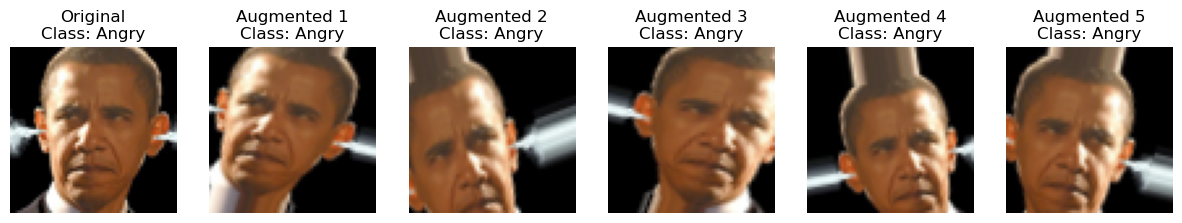

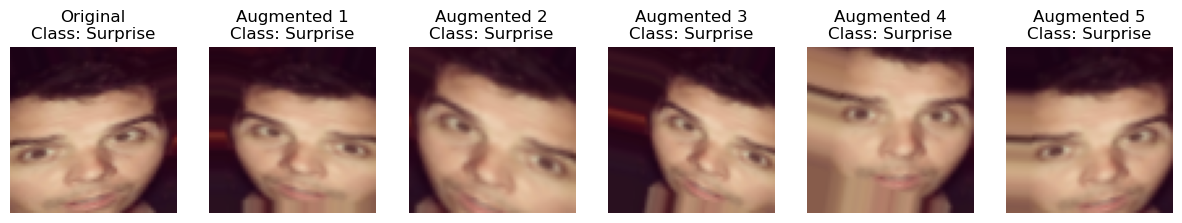

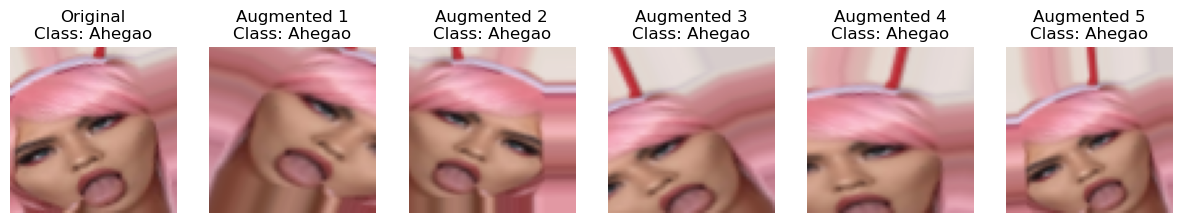

In [8]:
# Function to display original and augmented versions of the same image for each class
def display_original_and_augmented_for_each_class(image_data, labels, minority_classes, samples_per_class=5):
    for class_name in minority_classes:
        class_indices = [i for i, label in enumerate(labels) if label == class_name]

        if len(class_indices) > 0:
            # Select a random image index for the class
            random_index = np.random.choice(class_indices)

            img_original = image_data[random_index]
            label = labels[random_index]

            # Reshape the image to (1, height, width, channels) as required by flow method
            img_original = img_original.reshape((1,) + img_original.shape)

            # Create an ImageDataGenerator with the same augmentation settings used during training
            datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )

            # Generate augmented versions of the original image
            augmented_images = [datagen.flow(img_original, batch_size=1)[0][0] for _ in range(samples_per_class)]

            # Display original and augmented images
            plt.figure(figsize=(15, 5))
            plt.subplot(1, samples_per_class + 1, 1)
            plt.imshow(img_original[0])
            plt.title(f"Original\nClass: {label}")
            plt.axis('off')

            for i, augmented_img in enumerate(augmented_images, 2):
                plt.subplot(1, samples_per_class + 1, i)
                plt.imshow(augmented_img)
                plt.title(f"Augmented {i-1}\nClass: {label}")
                plt.axis('off')

            plt.show()

# Display original and augmented versions for each class with augmentation
display_original_and_augmented_for_each_class(images, labels, minority_classes=['Angry', 'Surprise', 'Ahegao'])


In [9]:
def display_original_and_augmented_for_each_class(image_data, labels, minority_classes, samples_per_class=5):
    for class_name in minority_classes:
        class_indices = [i for i, label in enumerate(labels) if class_name in label]

        if len(class_indices) > 0:
            # Select a random image index for the class
            random_index = np.random.choice(class_indices)

            img_original = image_data[random_index]
            label = labels[random_index]

            # Reshape the image to (1, height, width, channels) as required by flow method
            img_original = img_original.reshape((1,) + img_original.shape)

            # Create an ImageDataGenerator with the same augmentation settings used during training
            datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )

            # Generate augmented versions of the original image
            augmented_images = [datagen.flow(img_original, batch_size=1)[0][0] for _ in range(samples_per_class)]

            # Display original and augmented images
            plt.figure(figsize=(15, 5))
            plt.subplot(1, samples_per_class + 1, 1)
            plt.imshow(img_original[0])
            plt.title(f"Original\nClass: {label}")
            plt.axis('off')

            for i, augmented_img in enumerate(augmented_images, 2):
                plt.subplot(1, samples_per_class + 1, i)
                plt.imshow(augmented_img)
                plt.title(f"Augmented {i-1}\nClass: {label}")
                plt.axis('off')

            plt.show()

# Display original and augmented versions for each class with augmentation
display_original_and_augmented_for_each_class(X_train, y_train, minority_classes=['Angry', 'Surprise', 'Ahegao'])


C:\Users\JULIANA ROJAS\AppData\Local\Temp\ipykernel_8048\1940669284.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  class_indices = [i for i, label in enumerate(labels) if class_name in label]


In [10]:
import seaborn as sns

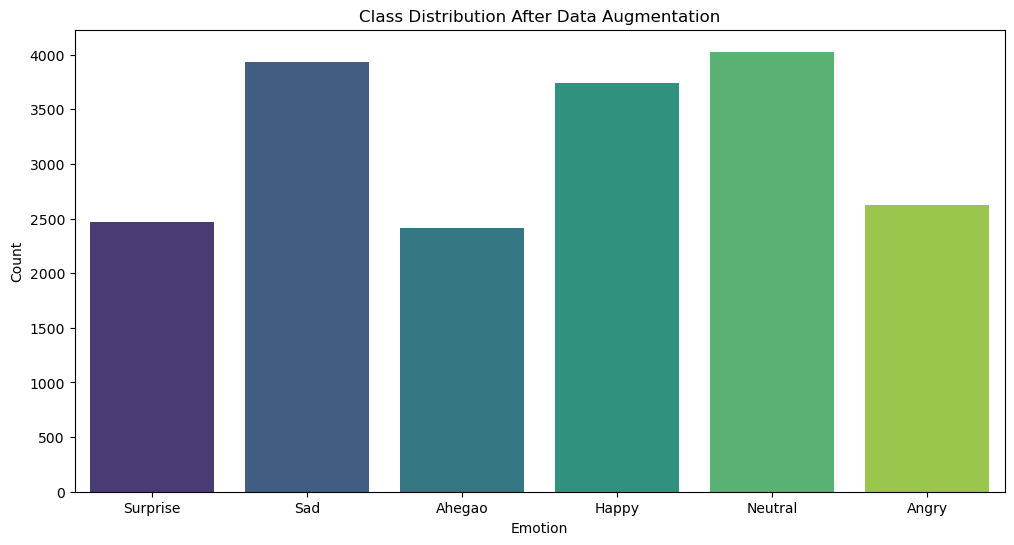

In [11]:
# Display count of original and augmented images for each class after augmentation
augmented_labels_encoded = label_encoder.transform(labels)

plt.figure(figsize=(12, 6))
sns.countplot(x=label_encoder.inverse_transform(augmented_labels_encoded), palette='viridis')
plt.title('Class Distribution After Data Augmentation')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [12]:
# Display summary of the number of images for all classes before and after data augmentation
original_class_counts = data['label'].value_counts()
augmented_class_counts = pd.Series(labels).value_counts()

summary_df = pd.DataFrame({
    'Class': original_class_counts.index,
    'Original Count': original_class_counts.values,
    'Augmented Count': augmented_class_counts.values
})

print(summary_df)

      Class  Original Count  Augmented Count
0   Neutral            4027             4027
1       Sad            3934             3934
2     Happy            3740             3740
3     Angry            1313             2626
4  Surprise            1234             2468
5    Ahegao            1205             2410


## CNN

### CNN without data augmentation

In [13]:
## CNN with augmentation and contrast

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageEnhance
from tensorflow.keras.callbacks import EarlyStopping

# Assuming you have X_train, y_train, X_test, y_test defined

def adjust_contrast(image, factor):
    enhancer = ImageEnhance.Contrast(image)
    enhanced_image = enhancer.enhance(factor)
    return np.array(enhanced_image) / 255.0

# Create data generator with augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Specify the target size and batch size
img_size = (64, 64)
batch_size = 32

# Create generator for training data
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
)

# Apply contrast adjustment separately
for i in range(len(train_generator)):
    batch_images = train_generator[i][0]
    for j in range(batch_images.shape[0]):
        image = batch_images[j]
        contrast_factor = np.random.uniform(0.5, 1.5)  # Adjust the range as needed
        batch_images[j] = adjust_contrast(Image.fromarray((image * 255).astype(np.uint8)), contrast_factor)

# Build the CNN model
model_cnn1 = Sequential()
model_cnn1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model_cnn1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model_cnn1.add(MaxPooling2D((2, 2)))
model_cnn1.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn1.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn1.add(MaxPooling2D((2, 2)))
model_cnn1.add(Flatten())
model_cnn1.add(Dense(128, activation='relu'))
model_cnn1.add(Dense(128, activation='relu'))
model_cnn1.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model_cnn1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with data augmentation and early stopping
history = model_cnn1.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Evaluate the model
accuracy = model_cnn1.evaluate(X_test, y_test)[1]
print("Test Accuracy: {:.2f}%".format(accuracy * 100))




Epoch 1/50


480/480 [==============================] - 103s 212ms/step - loss: 1.7047 - accuracy: 0.2484 - val_loss: 1.5679 - val_accuracy: 0.3158
Epoch 2/50
480/480 [==============================] - 101s 210ms/step - loss: 1.5807 - accuracy: 0.3236 - val_loss: 1.4461 - val_accuracy: 0.3890
Epoch 3/50
480/480 [==============================] - 100s 209ms/step - loss: 1.5221 - accuracy: 0.3574 - val_loss: 1.3911 - val_accuracy: 0.4106
Epoch 4/50
480/480 [==============================] - 102s 211ms/step - loss: 1.4722 - accuracy: 0.3781 - val_loss: 1.3645 - val_accuracy: 0.4389
Epoch 5/50
480/480 [==============================] - 100s 209ms/step - loss: 1.4264 - accuracy: 0.4046 - val_loss: 1.2893 - val_accuracy: 0.4723
Epoch 6/50
480/480 [==============================] - 100s 208ms/step - loss: 1.3586 - accuracy: 0.4382 - val_loss: 1.1938 - val_accuracy: 0.5288
Epoch 7/50
480/480 [==============================] - 98s 204ms/step - loss: 1.2822 - accuracy: 0.4852 - val_loss: 1.10

### CNN with data augmentation

In [14]:

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageEnhance
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt  # Import matplotlib for visualization

# Assuming you have X_train, y_train, X_test, y_test defined

def adjust_contrast(image, factor):
    enhancer = ImageEnhance.Contrast(image)
    enhanced_image = enhancer.enhance(factor)
    return np.array(enhanced_image) / 255.0

def display_original_and_augmented_for_each_class(image_data, labels, minority_classes, samples_per_class=5):
    for class_name in minority_classes:
        class_indices = [i for i, label in enumerate(labels) if class_name in label]

        if len(class_indices) > 0:
            # Select a random image index for the class
            random_index = np.random.choice(class_indices)

            img_original = image_data[random_index]
            label = labels[random_index]

            # Reshape the image to (1, height, width, channels) as required by flow method
            img_original = img_original.reshape((1,) + img_original.shape)

            # Create an ImageDataGenerator with the same augmentation settings used during training
            datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )

            # Generate augmented versions of the original image
            augmented_images = [datagen.flow(img_original, batch_size=1)[0][0] for _ in range(samples_per_class)]

            # Display original and augmented images
            plt.figure(figsize=(15, 5))
            plt.subplot(1, samples_per_class + 1, 1)
            plt.imshow(img_original[0])
            plt.title(f"Original\nClass: {label}")
            plt.axis('off')

            for i, augmented_img in enumerate(augmented_images, 2):
                plt.subplot(1, samples_per_class + 1, i)
                plt.imshow(augmented_img)
                plt.title(f"Augmented {i-1}\nClass: {label}")
                plt.axis('off')

            plt.show()

# Display original and augmented versions for each class with augmentation
display_original_and_augmented_for_each_class(X_train, y_train, minority_classes=['Angry', 'Surprise', 'Ahegao'])

# Build the CNN model
model_cnn2 = Sequential()
model_cnn2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model_cnn2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model_cnn2.add(MaxPooling2D((2, 2)))
model_cnn2.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn2.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn2.add(MaxPooling2D((2, 2)))
model_cnn2.add(Flatten())
model_cnn2.add(Dense(128, activation='relu'))
model_cnn2.add(Dense(128, activation='relu'))
model_cnn2.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model_cnn2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with data augmentation and early stopping
history = model_cnn2.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Evaluate the model
accuracy = model_cnn2.evaluate(X_test, y_test)[1]
print("Test Accuracy: {:.2f}%".format(accuracy * 100))


C:\Users\JULIANA ROJAS\AppData\Local\Temp\ipykernel_8048\1866588.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  class_indices = [i for i, label in enumerate(labels) if class_name in label]


Epoch 1/50
480/480 [==============================] - 100s 204ms/step - loss: 1.6768 - accuracy: 0.2582 - val_loss: 1.6100 - val_accuracy: 0.3030
Epoch 2/50
480/480 [==============================] - 97s 202ms/step - loss: 1.5846 - accuracy: 0.3222 - val_loss: 1.4854 - val_accuracy: 0.3757
Epoch 3/50
480/480 [==============================] - 99s 206ms/step - loss: 1.5144 - accuracy: 0.3577 - val_loss: 1.4097 - val_accuracy: 0.4046
Epoch 4/50
480/480 [==============================] - 105s 219ms/step - loss: 1.4494 - accuracy: 0.3825 - val_loss: 1.3421 - val_accuracy: 0.4439
Epoch 5/50
480/480 [==============================] - 108s 226ms/step - loss: 1.3820 - accuracy: 0.4218 - val_loss: 1.2023 - val_accuracy: 0.5202
Epoch 6/50
480/480 [==============================] - 109s 228ms/step - loss: 1.2809 - accuracy: 0.4768 - val_loss: 1.1273 - val_accuracy: 0.5504
Epoch 7/50
480/480 [==============================] - 101s 210ms/step - loss: 1.2122 - accuracy: 0.5089 - val_loss: 1.0552 - v

# RNN

In [15]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import Adam

# Load and preprocess images
images, labels = load_and_preprocess_images(images_folder)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
encoded_labels = to_categorical(encoded_labels)

# Add a time dimension to the images
images_with_time_dim = np.expand_dims(images, axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_with_time_dim, encoded_labels, test_size=0.2, random_state=42)

# Build an RNN model with LSTM layer
model_rnn1 = Sequential()
model_rnn1.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(None, 64, 64, 3)))
model_rnn1.add(TimeDistributed(MaxPooling2D((2, 2))))
model_rnn1.add(TimeDistributed(Flatten()))
model_rnn1.add(LSTM(128, activation='relu', return_sequences=True))  # Increased LSTM units and return_sequences
model_rnn1.add(LSTM(64, activation='relu'))  # Added a second LSTM layer
model_rnn1.add(Dense(256, activation='relu'))  # Adjusted Dense layer units
model_rnn1.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model_rnn1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduling
model_rnn1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model_rnn1.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch 1/50
481/481 [==============================] - 100s 201ms/step - loss: 1.5385 - accuracy: 0.3379 - val_loss: 1.4332 - val_accuracy: 0.4158
Epoch 2/50
481/481 [==============================] - 93s 194ms/step - loss: 1.2896 - accuracy: 0.4777 - val_loss: 1.2258 - val_accuracy: 0.5228
Epoch 3/50
481/481 [==============================] - 91s 190ms/step - loss: 1.1560 - accuracy: 0.5429 - val_loss: 1.1919 - val_accuracy: 0.5379
Epoch 4/50
481/481 [==============================] - 92s 191ms/step - loss: 1.0684 - accuracy: 0.5818 - val_loss: 1.2112 - val_accuracy: 0.5371
Epoch 5/50
481/481 [==============================] - 93s 193ms/step - loss: 1.0093 - accuracy: 0.6017 - val_loss: 1.1574 - val_accuracy: 0.5584
Epoch 6/50
481/481 [==============================] - 91s 190ms/step - loss: 0.9492 - accuracy: 0.6264 - val_loss: 1.0716 - val_accuracy: 0.5889
Epoch 7/50
481/481 [==============================] - 91s 190ms/step - loss: 0.9046 - accuracy: 0.6444 - val_loss: 1.0999 - val_a

# Transfer Learning

### Tranfer Learning with data augmentation

In [24]:
## With data augmentation
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load and preprocess images
images, labels = load_and_preprocess_images(images_folder)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
encoded_labels = to_categorical(encoded_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding custom top layers to the pre-trained base
model_tl1 = Sequential()
model_tl1.add(base_model)
model_tl1.add(Flatten())
model_tl1.add(Dense(256, activation='relu'))
model_tl1.add(Dropout(0.5))
model_tl1.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Compile the model
model_tl1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model_tl1.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,  # Adjust according to your dataset size
    epochs=20,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_tl1.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch 1/20
480/480 [==============================] - 1346s 3s/step - loss: 1.4903 - accuracy: 0.3785 - val_loss: 1.3534 - val_accuracy: 0.4514
Epoch 2/20
480/480 [==============================] - 4485s 9s/step - loss: 1.3898 - accuracy: 0.4300 - val_loss: 1.2672 - val_accuracy: 0.4879
Epoch 3/20
480/480 [==============================] - 1364s 3s/step - loss: 1.3580 - accuracy: 0.4418 - val_loss: 1.3101 - val_accuracy: 0.4567
Epoch 4/20
480/480 [==============================] - 4899s 10s/step - loss: 1.3383 - accuracy: 0.4496 - val_loss: 1.2559 - val_accuracy: 0.4869
Epoch 5/20
480/480 [==============================] - 703s 1s/step - loss: 1.3367 - accuracy: 0.4526 - val_loss: 1.2396 - val_accuracy: 0.4954
Epoch 6/20
480/480 [==============================] - 567s 1s/step - loss: 1.3226 - accuracy: 0.4673 - val_loss: 1.2443 - val_accuracy: 0.4936
Epoch 7/20
480/480 [==============================] - 456s 950ms/step - loss: 1.3103 - accuracy: 0.4661 - val_loss: 1.2118 - val_accuracy

### Transfer Learning without data augmentation

In [25]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# Load and preprocess images
images, labels = load_and_preprocess_images(images_folder)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
encoded_labels = to_categorical(encoded_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding custom top layers to the pre-trained base
model_tl2 = Sequential()
model_tl2.add(base_model)
model_tl2.add(Flatten())
model_tl2.add(Dense(256, activation='relu'))
model_tl2.add(Dropout(0.5))
model_tl2.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model_tl2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model_tl2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_tl2.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/50
481/481 [==============================] - 647s 1s/step - loss: 1.3589 - accuracy: 0.4402 - val_loss: 1.2294 - val_accuracy: 0.4858
Epoch 2/50
481/481 [==============================] - 609s 1s/step - loss: 1.2163 - accuracy: 0.5072 - val_loss: 1.1483 - val_accuracy: 0.5418
Epoch 3/50
481/481 [==============================] - 592s 1s/step - loss: 1.1683 - accuracy: 0.5252 - val_loss: 1.1272 - val_accuracy: 0.5371
Epoch 4/50
481/481 [==============================] - 646s 1s/step - loss: 1.1229 - accuracy: 0.5400 - val_loss: 1.1256 - val_accuracy: 0.5433
Epoch 5/50
481/481 [==============================] - 592s 1s/step - loss: 1.0897 - accuracy: 0.5588 - val_loss: 1.0927 - val_accuracy: 0.5413
Epoch 6/50
481/481 [==============================] - 511s 1s/step - loss: 1.0645 - accuracy: 0.5696 - val_loss: 1.0907 - val_accuracy: 0.5590
Epoch 7/50
481/481 [==============================] - 571s 1s/step - loss: 1.0461 - accuracy: 0.5743 - val_loss: 1.0796 - val_accuracy: 0.5749

# Real Time Emotion Recognition Application

In [ ]:
import cv2
import numpy as np
from keras.models import load_model
from PIL import Image


# Define the emotion labels
emotion_labels = ['Angry', 'Ahegao', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Function to preprocess the input frame for the model
def preprocess_frame(frame):
    img = Image.fromarray(frame)
    img = img.resize((64, 64))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to perform real-time emotion detection
def real_time_emotion_detection():
    # Open a connection to the webcam
    cap = cv2.VideoCapture(0)

    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Preprocess the frame
        processed_frame = preprocess_frame(frame)

        # Predict emotion using the model
        predictions = model_cnn1.predict(processed_frame)
        emotion_index = np.argmax(predictions)
        detected_emotion = emotion_labels[emotion_index]

        # Display the emotion on the frame
        cv2.putText(frame, f"Emotion: {detected_emotion}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Display the resulting frame
        cv2.imshow('Real-Time Emotion Detection', frame)

        # Break the loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcam and close all windows
    cap.release()
    cv2.destroyAllWindows()

# Run real-time emotion detection
real_time_emotion_detection()


In [ ]:
import cv2
import numpy as np
from keras.models import load_model
from PIL import Image


# Define the emotion labels
emotion_labels = ['Angry', 'Ahegao', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Function to preprocess the input frame for the model
def preprocess_frame(frame):
    img = Image.fromarray(frame)
    img = img.resize((64, 64))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to perform real-time emotion detection
def real_time_emotion_detection():
    # Open a connection to the webcam
    cap = cv2.VideoCapture(0)

    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Preprocess the frame
        processed_frame = preprocess_frame(frame)

        # Predict emotion using the model
        predictions = model_cnn2.predict(processed_frame)
        emotion_index = np.argmax(predictions)
        detected_emotion = emotion_labels[emotion_index]

        # Display the emotion on the frame
        cv2.putText(frame, f"Emotion: {detected_emotion}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Display the resulting frame
        cv2.imshow('Real-Time Emotion Detection', frame)

        # Break the loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcam and close all windows
    cap.release()
    cv2.destroyAllWindows()

# Run real-time emotion detection
real_time_emotion_detection()
